<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Capstone Project: Acne detection using Convolutional Neural Network (Part 2/3)

---

## Contents:
- [1. Import Libraries](#1.-Import-libraries)
- [2. Load Data](#2.-Load-data)
- [3. EDA and Visualisation](#3.-EDA-and-Visualisation)
- [4. Data Preprocessing and Data Augmentation](#4.-Data-Preprocessing-and-Data-Augmentation)
- [5. Modelling](#5.-Modelling)
- [6. Save the model](#6.-Save-the-model)

## 1. Import libraries 

In [2]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report,confusion_matrix,plot_confusion_matrix,ConfusionMatrixDisplay

import cv2
import os
import numpy as np
import pandas as pd

from PIL import Image, ImageStat

## 2. Load data 

In [3]:
# To load Train data
path_dir=r'..\assets\assets_1\train'

In [4]:
# Name of folder in path "Train"
data_dir=os.listdir(path_dir)
data_dir

['ACNE', 'NON_ACNE']

In [5]:
# First photo in train->acne directory
os.listdir(path_dir+"\\ACNE\\")[0]

'Acne (10).jpg.jpg'

In [6]:
# Define labels and image size
labels = ['NON_ACNE', 'ACNE']
img_size = 150

In [7]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [8]:
# Convert image into numpy array with labels, image resize to 150X150
def get_data(data_dir):
    labels = ['NON_ACNE', 'ACNE']
    img_size = 150
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to 150 x 150
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [9]:
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

In [10]:
#train and validation data in np.array
train = get_data('../assets/assets_1/train')
val = get_data('../assets/assets_1/validation')

In [11]:
import pandas as pd
df=pd.DataFrame(train,columns=['image', 'label'])
df.head()

,image,label
0,"[[[0, 0, 2], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0
1,"[[[1, 0, 0], [1, 0, 0], [1, 0, 0], [0, 0, 0], ...",0
2,"[[[0, 0, 2], [0, 0, 2], [0, 0, 1], [0, 0, 0], ...",0
3,"[[[0, 1, 2], [3, 0, 0], [1, 1, 0], [0, 2, 0], ...",0
4,"[[[0, 1, 0], [0, 1, 0], [1, 0, 1], [4, 0, 0], ...",0


## 3. EDA and Visualisation

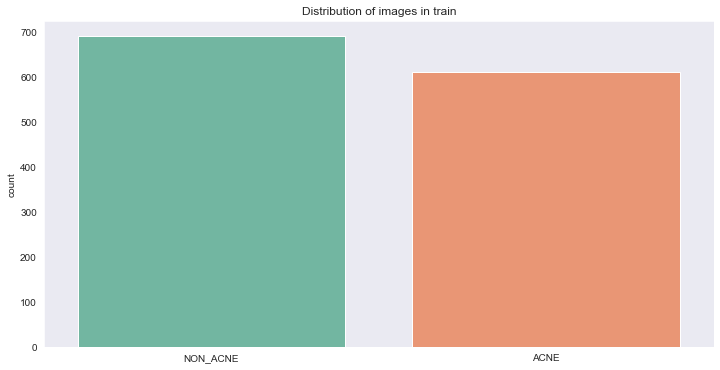

In [14]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("NON_ACNE")
    else:
        l.append("ACNE")
plt.figure(figsize=(12,6))
plt.title("Distribution of images in train")
sns.set_style('darkgrid')
sns.countplot(l,palette='Set2')
plt.grid(False)


There are 690 non-acne images and 610 acne images

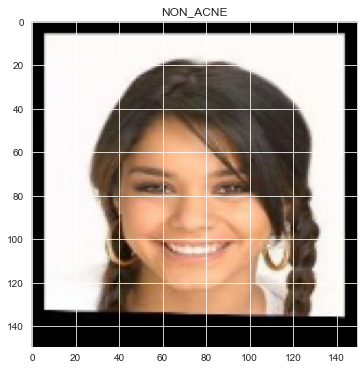

In [12]:
plt.figure(figsize = (6,6))
plt.imshow(train[1][0])
plt.title(labels[train[0][1]]);

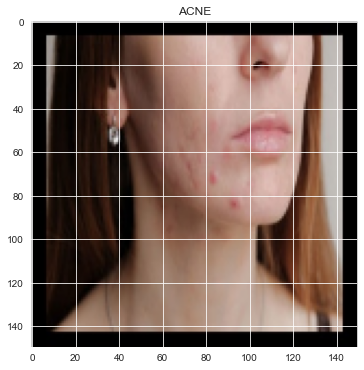

In [13]:
plt.figure(figsize = (6,6))
plt.imshow(train[-1][0])
plt.title(labels[train[-1][1]]);

In [15]:
# Plot the dimensions and color channel of the train acne data
# dim1 refers to height of image
# dim 2 refers to width of image
# color refers to colour channel
dim1=[]
dim2=[]
channel=[]
for image_filename in os.listdir(path_dir+'\\ACNE\\'):
    img=imread(path_dir+'\\ACNE\\'+image_filename)
    d1,d2,colors=img.shape
    dim1.append(d1)
    dim2.append(d2)
    channel.append(colors)

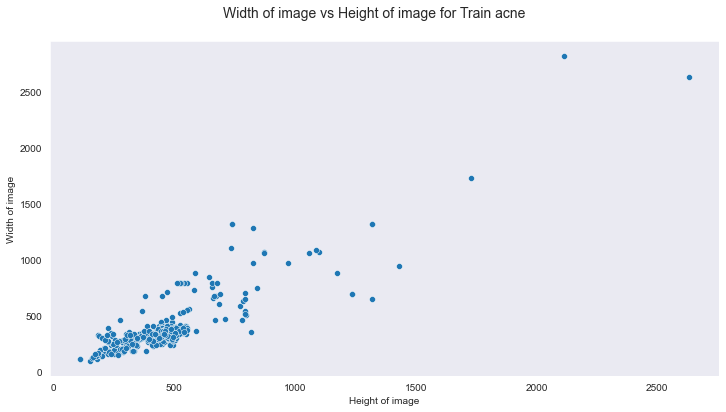

In [40]:
# To do a scatterplot to see the distribution of the dimension of the train acne images 
data = pd.DataFrame({
    'Height of image': dim1,
    'Width of image': dim2,
})
plt.figure(figsize=(12,6))
sns.scatterplot(x='Height of image', y='Width of image', data=data)
plt.subplots_adjust(top=0.9)
plt.suptitle('Width of image vs Height of image for Train acne', fontsize = 14)
plt.grid(b=None);

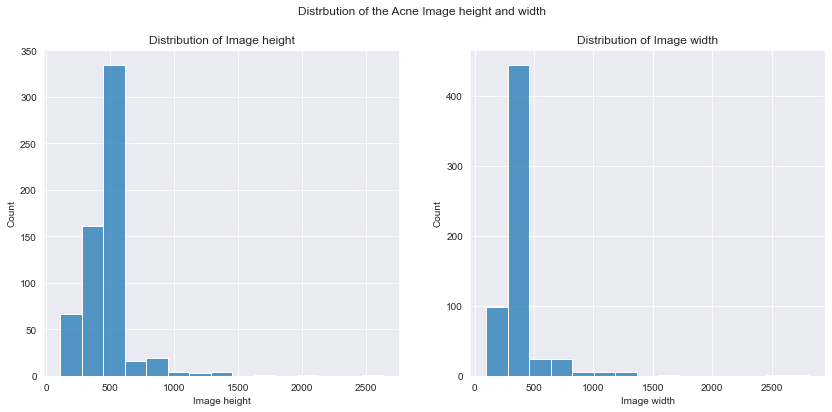

In [16]:
# Image height and width distribution 
fig,axes=plt.subplots(1,2,figsize=(14,6))
fig.suptitle('Distrbution of the Acne Image height and width')

sns.histplot(x=dim1, bins=15,ax=axes[0])
axes[0].set_title('Distribution of Image height')
axes[0].set_xlabel('Image height')


sns.histplot(x=dim2, bins=15,ax=axes[1])
axes[1].set_title('Distribution of Image width')
axes[1].set_xlabel('Image width');


Most images have height and width between 0 to 500.

In [17]:
# Mean of the train acne image height 
print(f'The mean height for train acne image is {round(np.mean(dim1))}.')

The mean height for train acne image is 469.


In [18]:
# Mean of the train acne image width
print(f'The mean width for train acne image is {round(np.mean(dim2))}.')

The mean width for train acne image is 376.


In [19]:
# Check if all the photos are colour
for x in channel:
    if x !=3:
        print("There is no RGB image")
        break
    else: 
        pass
print(f"{len(channel)} images checked.")

610 images checked.


In [21]:
# Plot the dimensions and color channel of the train non-acne data
# dim1 refers to height of image
# dim 2 refers to width of image
# color refers to colour channel
dim3=[]
dim4=[]
channel1=[]

for image_filename in os.listdir(path_dir+'\\NON_ACNE\\'):
    img=imread(path_dir+'\\NON_ACNE\\'+image_filename)
    d1,d2,colors=img.shape
    dim3.append(d1)
    dim4.append(d2)
    channel1.append(colors)

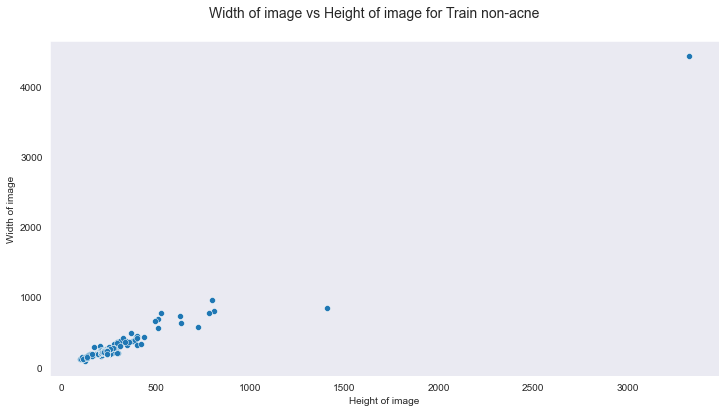

In [22]:
# To do a scatterplot to see the distribution of the dimension of the train non-acne images 
data1 = pd.DataFrame({
    'Height of image': dim3,
    'Width of image': dim4,
})
plt.figure(figsize=(12,6))
sns.scatterplot(x='Height of image', y='Width of image', data=data1)
plt.subplots_adjust(top=0.9)
plt.suptitle('Width of image vs Height of image for Train non-acne', fontsize = 14)
plt.grid(b=None);

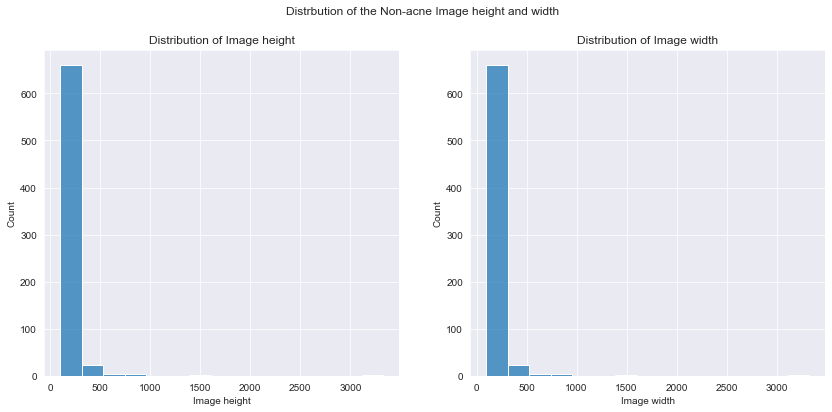

In [22]:
# Image height and width distribution 
fig,axes=plt.subplots(1,2,figsize=(14,6))
fig.suptitle('Distrbution of the Non-acne Image height and width')

sns.histplot(x=dim3, bins=15,ax=axes[0])
axes[0].set_title('Distribution of Image height')
axes[0].set_xlabel('Image height')

sns.histplot(x=dim3, bins=15,ax=axes[1])
axes[1].set_title('Distribution of Image width')
axes[1].set_xlabel('Image width');

In [23]:
# Mean of the image height 
print(f'The mean height for train non-acne image is {round(np.mean(dim3))}.')

The mean height for train non-acne image is 241.


In [24]:
# Mean of the image width
print(f'The mean width for train non-acne image is {round(np.mean(dim4))}.')

The mean width for train non-acne image is 235.


In [25]:
# Check if all the photos are colour
for x in channel1:
    if x !=3:
        print("There is no RGB image")
        break
    else: 
        pass
print(f"{len(channel1)} images checked.")

690 images checked.


In [24]:
# To find the brightness of the ACNE image by converting image to greyscale and return average pixel brightness.
brightness=[]

for image_filename in os.listdir(path_dir+'\\ACNE\\'):
    img=(path_dir+'\\ACNE\\'+image_filename)
    img=Image.open(img).convert('L')
    stat=ImageStat.Stat(img)
    mean=stat.mean[0]
    brightness.append(mean)

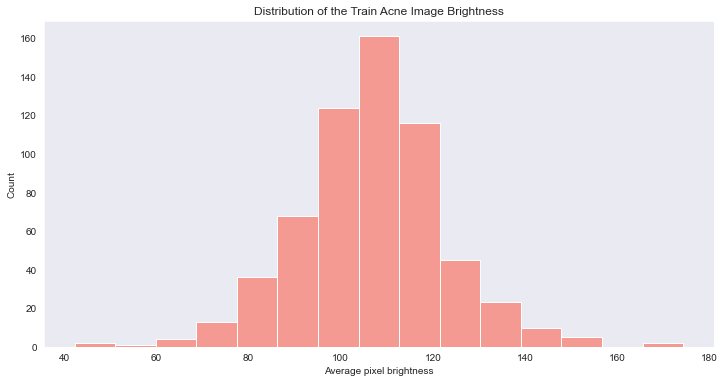

In [43]:
# Histogram to show the distribution for brightness of the ACNE images
plt.figure(figsize=(12, 6))
sns.histplot(x=brightness, bins=15,color='salmon')
plt.xlabel("Average pixel brightness")
plt.title("Distribution of the Train Acne Image Brightness")
plt.grid(b=None)

Most of the acne image have brightness average between 100 to 120.

In [57]:
# To find the brightness of the NON-ACNE image by converting image to greyscale and return average pixel brightness.
brightness=[]

for image_filename in os.listdir(path_dir+'\\NON_ACNE\\'):
    img=(path_dir+'\\NON_ACNE\\'+image_filename)
    img=Image.open(img).convert('L')
    stat=ImageStat.Stat(img)
    mean=stat.mean[0]
    brightness.append(mean)

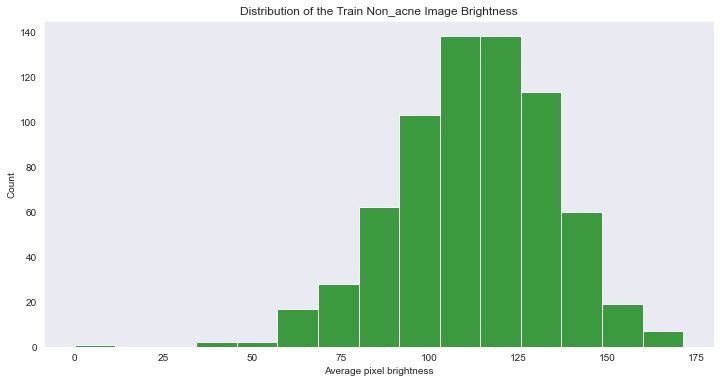

In [58]:
# Histogram to show the distribution for brightness of the NON-ACNE images
plt.figure(figsize=(12,6))
sns.histplot(x=brightness, bins=15,color='green')
plt.xlabel("Average pixel brightness")
plt.title("Distribution of the Train Non_acne Image Brightness")
plt.grid(b=None)

Most of the non-acne image have brightness average between 100 to 125.

## 4. Data Preprocessing and Data Augmentation

In [49]:
# Prepare train and validation data 
# x is the image info ; y is the label 

x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

for feature, label in val:
  x_val.append(feature)
  y_val.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

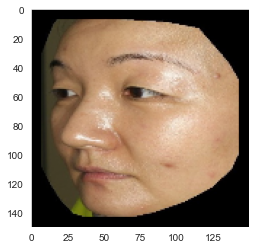

In [53]:
plt.imshow(x_train[1000])
plt.grid(b=None)

#### Notes: 
The reshape(-1) parameter means that to allow numpy to figure out the unknown dimension and yet making sure that it meet the requirement that the new shape should be compatible with the original shape.

In [51]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

#### Notes: 
Data augmentation is useful to improve performance and outcomes of machine learning models by forming new and different examples to train datasets. If dataset in a machine learning model is rich and sufficient, the model performs better and more accurate.

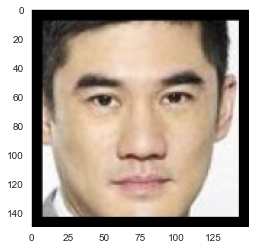

In [56]:
plt.imshow(x_train[10])
plt.grid(b=None)

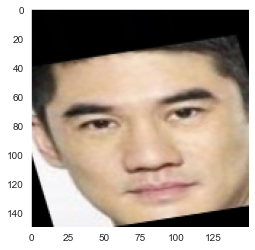

In [54]:
plt.imshow(datagen.random_transform((x_train)[10]))
plt.grid(b=None)

## 5. Modelling

In [33]:
# Instantiate a CNN.
model = Sequential()

# Add a convolutional layer.
model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=(150,150,3), activation='relu'))
# Add a pooling layer.
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add a convolutional layer.
model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=(150,150,3), activation='relu'))
# Add a pooling layer.
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add a convolutional layer.
model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=(150,150,3), activation='relu'))
# Add a pooling layer.
model.add(MaxPooling2D(pool_size=(2, 2)))

# to flatten from the "box" to the vertical line of nodes
model.add(Flatten())

# Add a densely-connected layer with 128 neurons.
model.add(Dense(128))
model.add(Activation('relu'))

# Dropouts help reduce overfitting by randomly turning neurons off during training.
# Here we say randomly turn off 50% of neurons.
model.add(Dropout(0.5))

# Last layer, remember its binary, 0= non-acne , 1= acne
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

In [35]:
BS=8
history = model.fit(x=datagen.flow(x_train,y_train,batch_size=BS),
                    validation_data = (x_val, y_val),
                    steps_per_epoch=len(x_train) // BS,
                    epochs = 100
                   )

Epoch 1/100
162/162 [==============================] - 25s 113ms/step - loss: 0.5738 - accuracy: 0.7113 - val_loss: 0.3750 - val_accuracy: 0.8840
Epoch 2/100
162/162 [==============================] - 16s 101ms/step - loss: 0.4611 - accuracy: 0.8073 - val_loss: 0.4081 - val_accuracy: 0.8422
Epoch 3/100
162/162 [==============================] - 16s 101ms/step - loss: 0.3875 - accuracy: 0.8491 - val_loss: 0.2294 - val_accuracy: 0.9142
Epoch 4/100
162/162 [==============================] - 16s 102ms/step - loss: 0.3626 - accuracy: 0.8622 - val_loss: 0.2833 - val_accuracy: 0.8933
Epoch 5/100
162/162 [==============================] - 16s 101ms/step - loss: 0.3691 - accuracy: 0.8638 - val_loss: 0.2869 - val_accuracy: 0.9095
Epoch 6/100
162/162 [==============================] - 16s 101ms/step - loss: 0.3352 - accuracy: 0.8808 - val_loss: 0.2491 - val_accuracy: 0.9072
Epoch 7/100
162/162 [==============================] - 17s 102ms/step - loss: 0.3201 - accuracy: 0.8738 - val_loss: 0.2184 -

In [36]:
metrics=pd.DataFrame(history.history)
metrics.tail()

,loss,accuracy,val_loss,val_accuracy
95,0.085381,0.968266,0.073437,0.972158
96,0.097640,0.964396,0.088848,0.965197
97,0.086992,0.967492,0.077166,0.979118
98,0.089876,0.965170,0.079408,0.974478
99,0.087612,0.971362,0.063571,0.974478


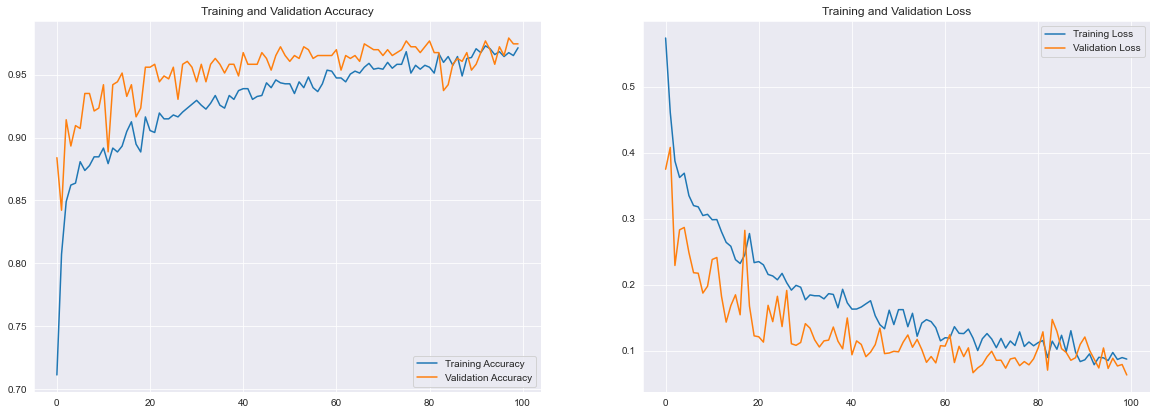

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(100)

plt.figure(figsize=(20, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [38]:
model.evaluate(x_train,y_train,verbose=0)

[0.03314276412129402, 0.9938461780548096]

In [39]:
model.evaluate(x_val,y_val,verbose=0)

[0.0635712593793869, 0.9744779467582703]

The model achieve ~97% accuracy. 

In [34]:
# Train prediction
predictions = (model.predict(x_train) > 0.5).astype("int32")
predictions = predictions.reshape(1,-1)[0]
print(classification_report(y_train, predictions, target_names = ['NON_ACNE','ACNE']))

              precision    recall  f1-score   support

    NON_ACNE       0.99      0.99      0.99       690
        ACNE       0.99      0.99      0.99       610

    accuracy                           0.99      1300
   macro avg       0.99      0.99      0.99      1300
weighted avg       0.99      0.99      0.99      1300



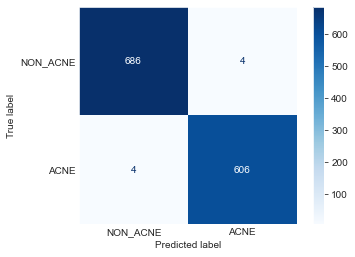

In [35]:
# Confusion matrix for validation prediction against label
target_names=['NON_ACNE','ACNE']
cm = confusion_matrix(y_train, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp = disp.plot(include_values=True,cmap='Blues')
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.grid(b=None)

In [41]:
# Validation prediction
predictions = (model.predict(x_val) > 0.5).astype("int32")
predictions = predictions.reshape(1,-1)[0]
print(classification_report(y_val, predictions, target_names = ['NON_ACNE','ACNE']))

              precision    recall  f1-score   support

    NON_ACNE       0.97      0.98      0.98       230
        ACNE       0.97      0.97      0.97       201

    accuracy                           0.97       431
   macro avg       0.97      0.97      0.97       431
weighted avg       0.97      0.97      0.97       431



#### Notes:

The metrics on the training set is to observe how well the model progress in terms of its training while metrics on the validation set is a measure of the quality of the model and its ability to make new predictions for unseen data. 

Initally, the training loss is higher because it was artificially made harder for the model to give the right answers by introducing data augmentation to the train data. However, during validation all of the units are available, so the network has its full computational power - and thus it might perform better than in training. Towards the end of the training, the accuracy of the train and validation becomes similar, the difference between the losses became similar too. 

As the dropout is set at 50%, some information about each image is lost due to disabling neurons and the subsequent layers attempt to construct predictions basing on incomplete representations. This resulted a fluctuation of losses shown in the graph. 

In conclusion, the model has an accuracy of 99% on the training set and 97% on the validation set. This means that the model can perform with ~97% on new data. 

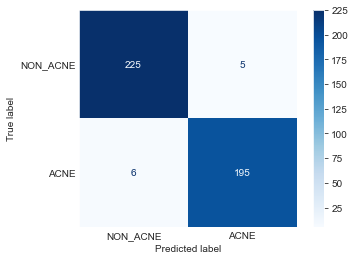

In [42]:
# Confusion matrix for validation prediction against label
target_names=['NON_ACNE','ACNE']
cm = confusion_matrix(y_val, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp = disp.plot(include_values=True,cmap='Blues')
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.grid(b=None)

## 6. Save the model

In [43]:
model.save("../model/model_epoch100.h5")